In [1]:
# Jupyter magic
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt  # standard Python plotting library

# import the tdt library
import tdt
import pandas as pd

In [85]:
blockpath = r"C:\Users\User\Tischfield_Lab\Fiber_Photo\Sample_Tank\EN174_RI30D3-240720-144035"
treatment = r"C:\Users\User\Tischfield_Lab\Fiber_Photo\Sample_Tank\Open Field tanks\Haloperidol tanks\het\EN182_OFH-240829-115021"
data = tdt.read_block(blockpath) # created a dictionary to read
treatdata = tdt.read_block(treatment)
isosbestic = '_415A'
dopa='_465A'

RMG     = 'RMG_'
URM = 'URM_'
STREAM_STORE = '_465A'   #seems to be having trouble finding this later on?
ARTIFACT     = np.inf       # optionally set an artifact rejection level (figure out what this actually does)
CHANNEL      = 1
TRANGE       = [-5, 10]  # window size [start time relative to epoc onset, window duration]
BASELINE_PER = [-5, 2]

read from t=0s to t=1799.09s
read from t=0s to t=1799.1s


In [60]:
# plt.plot(treatdata.streams[dopa].data)
# plt.plot(treatdata.streams[isosbestic].data)

In [86]:
data = tdt.read_block(blockpath)

read from t=0s to t=1799.09s


In [95]:
len(data.streams._415A.data)

1830016

C:\Users\User\AppData\Local\Temp\ipykernel_7164\1177599509.py:16: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax0.legend(handles=[p1,p2], loc='upper right')


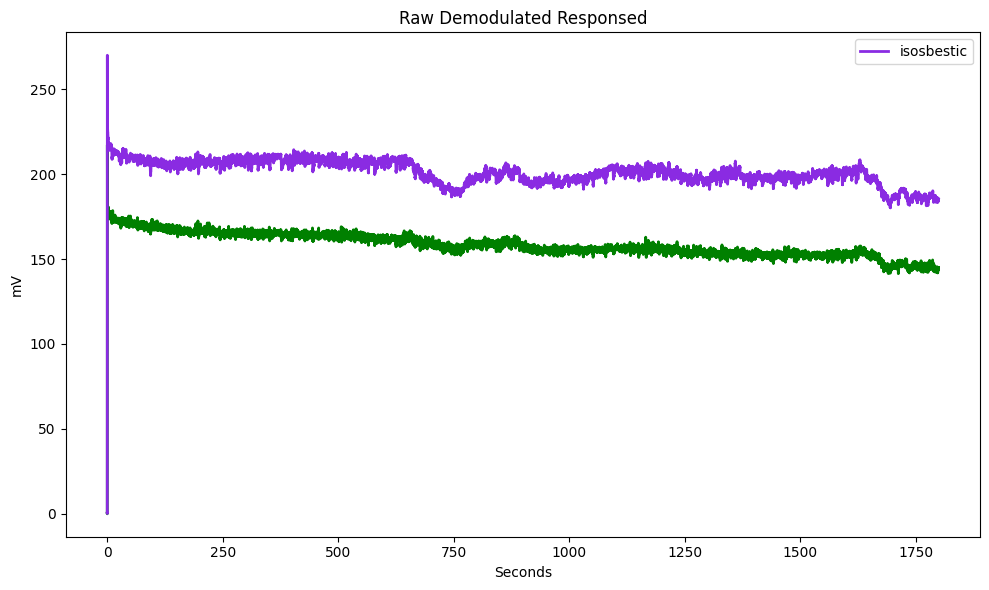

In [74]:
# Make a time array based on the number of samples and sample freq of 
# the demodulated streams
time = np.linspace(1,len(data.streams[dopa].data), len(data.streams[dopa].data))/data.streams[dopa].fs
timeT = np.linspace(1,len(treatdata.streams[dopa].data), len(treatdata.streams[dopa].data))/treatdata.streams[dopa].fs
# Plot both unprocessed demodulated stream            
fig1 = plt.figure(figsize=(10,6))
ax0 = fig1.add_subplot(111)

# Plotting the traces
p1, = ax0.plot(timeT, treatdata.streams[dopa].data, linewidth=2, color='green', label='_465B')
p2, = ax0.plot(timeT, treatdata.streams[isosbestic].data, linewidth=2, color='blueviolet', label='isosbestic')

ax0.set_ylabel('mV')
ax0.set_xlabel('Seconds')
ax0.set_title('Raw Demodulated Responsed')
ax0.legend(handles=[p1,p2], loc='upper right')
fig1.tight_layout()

# Jupyter for some reason (sometimes) shows the figure without be called, 
# Likely when plt.figure() is called
# otherwise you would call fig in a line by itself like:
# fig


C:\Users\User\AppData\Local\Temp\ipykernel_7164\924921549.py:27: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax1.legend(handles=[p1,p2],loc='upper right')


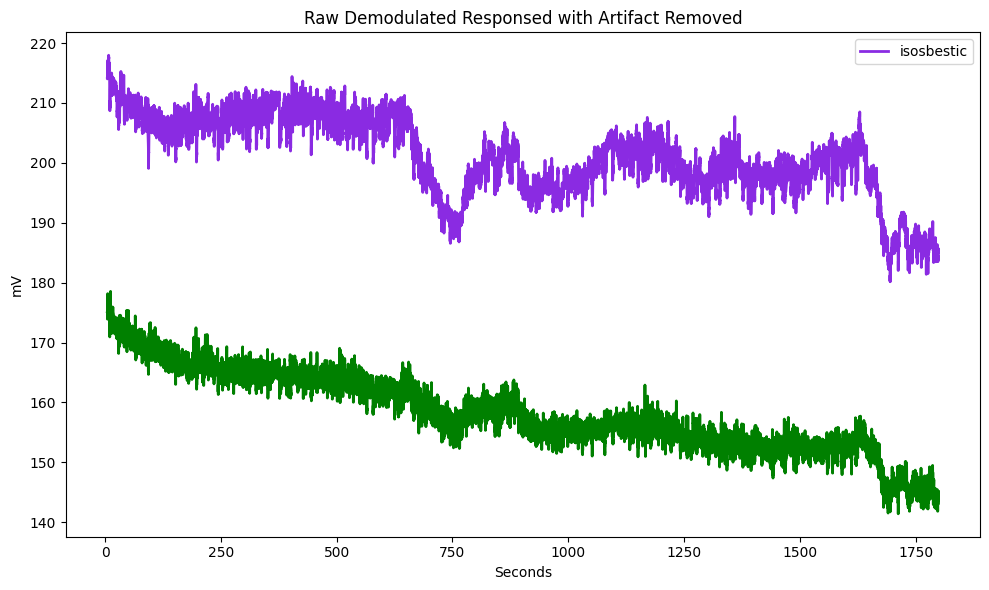

In [75]:
# There is often a large artifact on the onset of LEDs turning on
# Remove data below a set time t
t = 5
inds = np.where(time>t)
tinds = np.where(timeT>t)
tind = tinds[0][0]
ind = inds[0][0]
time = time[ind:] # go from ind to final index
timeT = timeT[tind:]
data.streams[dopa].data = data.streams[dopa].data[ind:]
data.streams[isosbestic].data = data.streams[isosbestic].data[ind:]
treatdata.streams[dopa].data = treatdata.streams[dopa].data[tind:]
treatdata.streams[isosbestic].data = treatdata.streams[isosbestic].data[tind:]


# Plot again at new time range
fig2 = plt.figure(figsize=(10, 6))
ax1 = fig2.add_subplot(111)

# Plotting the traces
p1, = ax1.plot(timeT,treatdata.streams[dopa].data, linewidth=2, color='green', label='_465B')
p2, = ax1.plot(timeT,treatdata.streams[isosbestic].data, linewidth=2, color='blueviolet', label='isosbestic')

ax1.set_ylabel('mV')
ax1.set_xlabel('Seconds')
ax1.set_title('Raw Demodulated Responsed with Artifact Removed')
ax1.legend(handles=[p1,p2],loc='upper right')
fig2.tight_layout()
# fig


In [76]:
# Average around every Nth point and downsample Nx
N = 10 # Average every 10 samples into 1 value
F415 = []
F465 = []

for i in range(0, len(data.streams[dopa].data), N):
    F465.append(np.mean(data.streams[dopa].data[i:i+N-1])) # This is the moving window mean
data.streams[dopa].data = F465

for i in range(0, len(data.streams[isosbestic].data), N):
    F415.append(np.mean(data.streams[isosbestic].data[i:i+N-1]))
data.streams[isosbestic].data = F415

#decimate time array to match length of demodulated stream
time = time[::N] # go from beginning to end of array in steps on N
time = time[:len(data.streams[dopa].data)]

# Detrending and dFF
# Full trace dFF according to Lerner et al. 2015
# https://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline

x = np.array(data.streams[isosbestic].data)
y = np.array(data.streams[dopa].data)
bls = np.polyfit(x, y, 1)
Y_fit_all = np.multiply(bls[0], x) + bls[1]
Y_dF_all = y - Y_fit_all

dFF = np.multiply(100, np.divide(Y_dF_all, Y_fit_all))
std_dFF = np.std(dFF)


In [77]:
# Average around every Nth point and downsample Nx
N = 10 # Average every 10 samples into 1 value
F415 = []
F465 = []

for i in range(0, len(treatdata.streams[dopa].data), N):
    F465.append(np.mean(treatdata.streams[dopa].data[i:i+N-1])) # This is the moving window mean
treatdata.streams[dopa].data = F465

for i in range(0, len(treatdata.streams[isosbestic].data), N):
    F415.append(np.mean(treatdata.streams[isosbestic].data[i:i+N-1]))
treatdata.streams[isosbestic].data = F415

#decimate time array to match length of demodulated stream
timeT = timeT[::N] # go from beginning to end of array in steps on N
timeT = timeT[:len(treatdata.streams[dopa].data)]

# Detrending and dFF
# Full trace dFF according to Lerner et al. 2015
# https://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline

x = np.array(treatdata.streams[isosbestic].data)
y = np.array(treatdata.streams[dopa].data)
bls = np.polyfit(x, y, 1)
Y_fit_all = np.multiply(bls[0], x) + bls[1]
Y_dF_all = y - Y_fit_all

treatdFF = np.multiply(100, np.divide(Y_dF_all, Y_fit_all))
treat_std_dFF = np.std(treatdFF)

C:\Users\User\AppData\Local\Temp\ipykernel_7164\3485993119.py:25: RankWarning: Polyfit may be poorly conditioned
  bls = np.polyfit(x, y, 1)


In [71]:
# # First make a continous time series of Licking TTL events (epocs) and plot
# mag_on = data.epocs[RMG].onset
# mag_off = data.epocs[RMG].offset
# # Add the first and last time stamps to make tails on the TTL stream
# mag_x = np.append(np.append(time[0], np.reshape(np.kron([mag_on, mag_on+1],
#                    np.array([[1], [1]])).T, [1,-1])[0]), time[-1])
# sz = len(mag_on)
# d = data.epocs[RMG].data
# # Add zeros to beginning and end of 0,1 value array to match len of LICK_x
# LICK_y = np.append(np.append(0,np.reshape(np.vstack([np.zeros(sz),
#     d, d, np.zeros(sz)]).T, [1, -1])[0]),0)

# y_scale = 10 #adjust according to data needs
# y_shift = -20 #scale and shift are just for aesthetics


In [15]:
# # First make a continous time series of Licking TTL events (epocs) and plot
# urm_on = data.epocs[URM].onset
# urm_off = data.epocs[URM].offset
# # Add the first and last time stamps to make tails on the TTL stream
# urm_x = np.append(np.append(time[0], np.reshape(np.kron([urm_on, urm_on+1],
#                    np.array([[1], [1]])).T, [1,-1])[0]), time[-1])
# sz2 = len(urm_on)
# d2 = data.epocs[URM].data
# # Add zeros to beginning and end of 0,1 value array to match len of LICK_x
# urm_y = np.append(np.append(0,np.reshape(np.vstack([np.zeros(sz2),
#     d2, d2, np.zeros(sz2)]).T, [1, -1])[0]),0)

# y_scale2 = 10 #adjust according to data needs
# y_shift2 = -20 #scale and shift are just for aesthetics


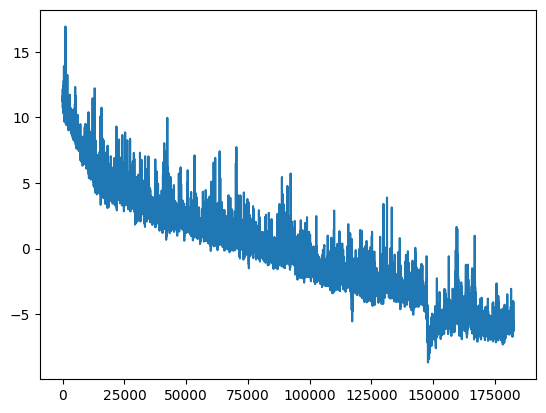

In [50]:
plt.plot(treatdFF)

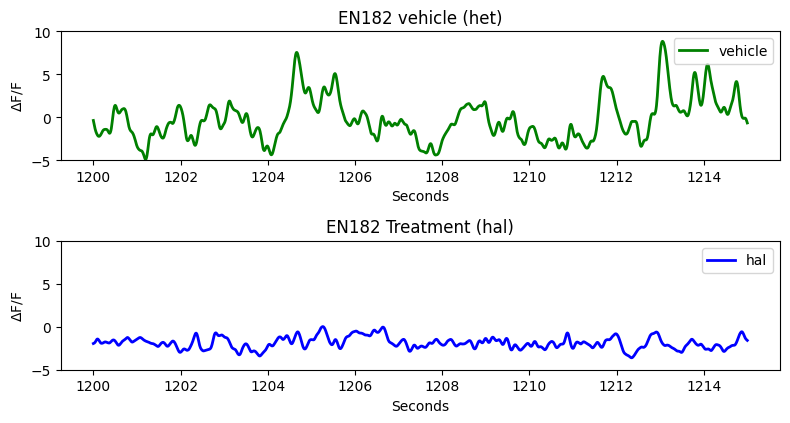

In [81]:
# First subplot in a series: dFF with lick epocs

tstart = 20
tend = 20.25
timesplit = np.linspace(tstart*60, tend*60, int(15*101.8))
fig3 = plt.figure(figsize=(8,6))
ax2 = fig3.add_subplot(311)
split = dFF[int(tstart*60*101.8): int(tend*60*101.8)]
treat_split = treatdFF[int(tstart*60*101.8): int(tend*60*101.8)]
ax3 = fig3.add_subplot(312)
p1, = ax2.plot(timesplit, split, linewidth=2, color='green', label='vehicle')
p2, = ax3.plot(timesplit, treat_split, linewidth = 2, color = 'blue', label = 'hal')
# p2, = ax2.plot(mag_x, y_scale*LICK_y+y_shift, linewidth=2, color='dodgerblue', label='Rewarded Mag')
# p3, = ax2.plot(urm_x, y_scale2*urm_y+y_shift, linewidth=2, color='red', label='URM')
ax2.set_ylabel(r'$\Delta$F/F')
ax2.set_ylim([-5,10])
ax2.set_xlabel('Seconds')
ax2.set_title('EN182 vehicle (het)')
ax2.legend(loc='upper right')
ax3.legend(loc = 'upper right')
ax3.set_ylabel(r'$\Delta$F/F')
ax3.set_xlabel('Seconds')
ax3.set_ylim([-5,10])
ax3.set_title('EN182 Treatment (hal)')
fig3.tight_layout()


In [17]:
urm_on_list = np.array(data['epocs'][URM]['onset']).tolist()
before = len(urm_on_list)
filtered_urm_on = urm_on_list
rmg_on_list = np.array(data['epocs'][RMG]['onset']).tolist()

t_exclude = 5 # time threshold

for i in rmg_on_list:
    for j in urm_on_list:
        if (j-i <t_exclude) & (j-i>0):  
            filtered_urm_on.remove(j)    
events_removed= before - len(filtered_urm_on)
filtered_urm_on=np.array(filtered_urm_on)
print(events_removed)
data['epocs'][URM]['onset']= filtered_urm_on

11


In [18]:
data_list = np.array(data['epocs'][URM]['data']).tolist()
for i in range(events_removed):
    data_list.remove(data_list[i])
data['epocs'][URM]['data']= np.array(data_list)

In [19]:
# First make a continous time series of Licking TTL events (epocs) and plot
f_urm_on = data.epocs[URM].onset
f_urm_off = data.epocs[URM].offset
# Add the first and last time stamps to make tails on the TTL stream
f_urm_x = np.append(np.append(time[0], np.reshape(np.kron([f_urm_on, f_urm_on+1],
                   np.array([[1], [1]])).T, [1,-1])[0]), time[-1])
fsz2 = len(f_urm_on)
fd2 = data.epocs[URM].data
# Add zeros to beginning and end of 0,1 value array to match len of LICK_x
f_urm_y = np.append(np.append(0,np.reshape(np.vstack([np.zeros(fsz2),
    fd2, fd2, np.zeros(fsz2)]).T, [1, -1])[0]),0)

fy_scale2 = 10 #adjust according to data needs
fy_shift2 = -20 #scale and shift are just for aesthetics


In [20]:
Mag_Event = 'Mag_Event'

Mag_DICT = {
        "name":Mag_Event,
        "onset":[],
        "offset":[],
        "type_str":data.epocs[RMG].type_str,
        "data":[]
        }
# pass StructType our new dictionary to make keys and values
data.epocs.Mag_Event = tdt.StructType(Mag_DICT)

lick_on_diff = np.diff(data.epocs[RMG].onset)
BOUT_TIME_THRESHOLD = 5
lick_diff_ind = np.where(lick_on_diff >= BOUT_TIME_THRESHOLD)[0]
#for some reason np.where returns a 2D array, hence the [0]

# Make an onset/ offset array based on threshold indicies
diff_ind = 0
for ind in lick_diff_ind: 
    # BOUT onset is thresholded onset index of lick epoc event
    data.epocs[Mag_Event].onset.append(data.epocs[RMG].onset[diff_ind])
    # BOUT offset is thresholded offset of lick event before next onset
    data.epocs[Mag_Event].offset.append(data.epocs[RMG].offset[ind])
    # set the values for data, arbitrary 1
    data.epocs[Mag_Event].data.append(1)
    diff_ind = ind + 1

# special case for last event to handle lick event offset indexing
data.epocs[Mag_Event].onset.append(data.epocs[RMG].onset[lick_diff_ind[-1]+1])
data.epocs[Mag_Event].offset.append(data.epocs[RMG].offset[-1])
data.epocs[Mag_Event].data.append(1)

# Now determine if it was a 'real' lick bout by thresholding by some
# user-set number of licks in a row
MIN_LICK_THRESH = 4 #four licks or more make a bout
licks_array = []

# Find number of licks in licks_array between onset and offset of 
# our new lick BOUT LICK_EVENT
for on, off in zip(data.epocs[Mag_Event].onset,data.epocs[Mag_Event].offset):
    licks_array.append(
        len(np.where((data.epocs[RMG].onset >= on) & (data.epocs[RMG].onset <= off))[0]))

# Remove onsets, offsets, and data of thrown out events
licks_array = np.array(licks_array)
inds = np.where(licks_array<MIN_LICK_THRESH)[0]
for index in sorted(inds, reverse=True):
    del data.epocs[Mag_Event].onset[index]
    del data.epocs[Mag_Event].offset[index]
    del data.epocs[Mag_Event].data[index]

# Make a continuous time series for lick BOUTS for plotting
Mag_Event_on = data.epocs[Mag_Event].onset
Mag_Event_off = data.epocs[Mag_Event].offset
Mag_Event_x = np.append(time[0], np.append(
    np.reshape(np.kron([Mag_Event_on, Mag_Event_off],np.array([[1], [1]])).T, [1,-1])[0], time[-1]))
sz = len(Mag_Event_on)
d = data.epocs[Mag_Event].data
Mag_Event_y = np.append(np.append(
    0, np.reshape(np.vstack([np.zeros(sz), d, d, np.zeros(sz)]).T, [1 ,-1])[0]), 0)


C:\Users\Tischfield\AppData\Local\Temp\ipykernel_2712\1398291058.py:9: UserWarning: The label '_465B' of <matplotlib.lines.Line2D object at 0x000001C6A8787C40> starts with '_'. It is thus excluded from the legend.
  axnew.legend(handles=[p1,p2,pnew], loc='upper right')


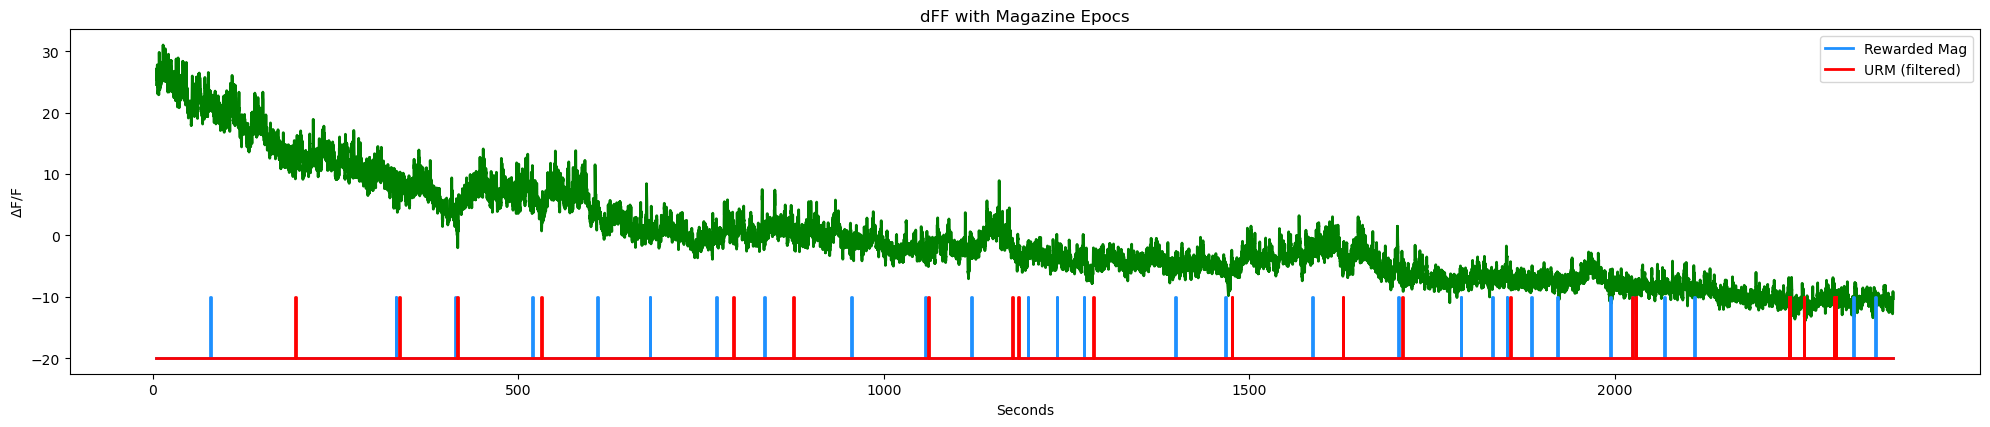

In [21]:
fig5 = plt.figure(figsize=(20,12))
axnew = fig5.add_subplot(311)
p1, = axnew.plot(time, dFF, linewidth=2, color='green', label='_465B')
p2, = axnew.plot(mag_x, y_scale*LICK_y+y_shift, linewidth=2, color='dodgerblue', label='Rewarded Mag')
pnew, = axnew.plot(f_urm_x, fy_scale2*f_urm_y+y_shift, linewidth=2, color='red', label='URM (filtered)')
axnew.set_ylabel(r'$\Delta$F/F')
axnew.set_xlabel('Seconds')
axnew.set_title('dFF with Magazine Epocs')
axnew.legend(handles=[p1,p2,pnew], loc='upper right')
fig5.tight_layout()

In [22]:
# ax3 = fig3.add_subplot(312)
# p1, = ax3.plot(time, dFF, linewidth=2, color='green', label='_465')
# p2, = ax3.plot(Mag_Event_x, y_scale*Mag_Event_y+y_shift, linewidth=2, color='dodgerblue', label='Mag Bout')
# ax3.set_ylabel(r'$\Delta$F/F')
# ax3.set_xlabel('Seconds')
# ax3.set_title('dFF with Magazine Bouts')
# ax3.legend(handles=[p1, p2], loc='upper right')

# ax4 = fig3.add_subplot(313)
# p1, = ax4.plot(time, dFF,linewidth=2, color='green', label='_465B')
# for on, off in zip(data.epocs[Mag_Event].onset, data.epocs[Mag_Event].offset):
#     ax4.axvspan(on, off, alpha=0.25, color='dodgerblue')
# ax4.set_ylabel(r'$\Delta$F/F')
# ax4.set_xlabel('Seconds')
# ax4.set_title('dFF with Mag Bouts')
# fig3.tight_layout()
# fig3


In [23]:
PRE_TIME = 5 # five seconds before event onset
POST_TIME = 10 # ten seconds after
fs = data.streams[dopa].fs/N #recall we downsampled by N = 10 earlier

# time span for peri-event filtering, PRE and POST, in samples
TRANGE = [-PRE_TIME*np.floor(fs), POST_TIME*np.floor(fs)]

dFF_snips = []
array_ind = []
pre_stim = []
post_stim = []

for on in data.epocs[URM].onset:
    # If the bout cannot include pre-time seconds before event, make zero
    if on < PRE_TIME:
        dFF_snips.append(np.zeros(TRANGE[1]-TRANGE[0]))
    else: 
        # find first time index after bout onset
        array_ind.append(np.where(time > on)[0][0])
        # find index corresponding to pre and post stim durations
        pre_stim.append(array_ind[-1] + TRANGE[0])
        post_stim.append(array_ind[-1] + TRANGE[1])
        dFF_snips.append(dFF[int(pre_stim[-1]):int(post_stim[-1])])

# Make all snippets the same size based on min snippet length
min1 = np.min([np.size(x) for x in dFF_snips])
dFF_snips = [x[1:min1] for x in dFF_snips]

mean_dFF_snips = np.mean(dFF_snips, axis=0)
std_dFF_snips = np.std(mean_dFF_snips, axis=0)

peri_time = np.linspace(1, len(mean_dFF_snips), len(mean_dFF_snips))/fs - PRE_TIME



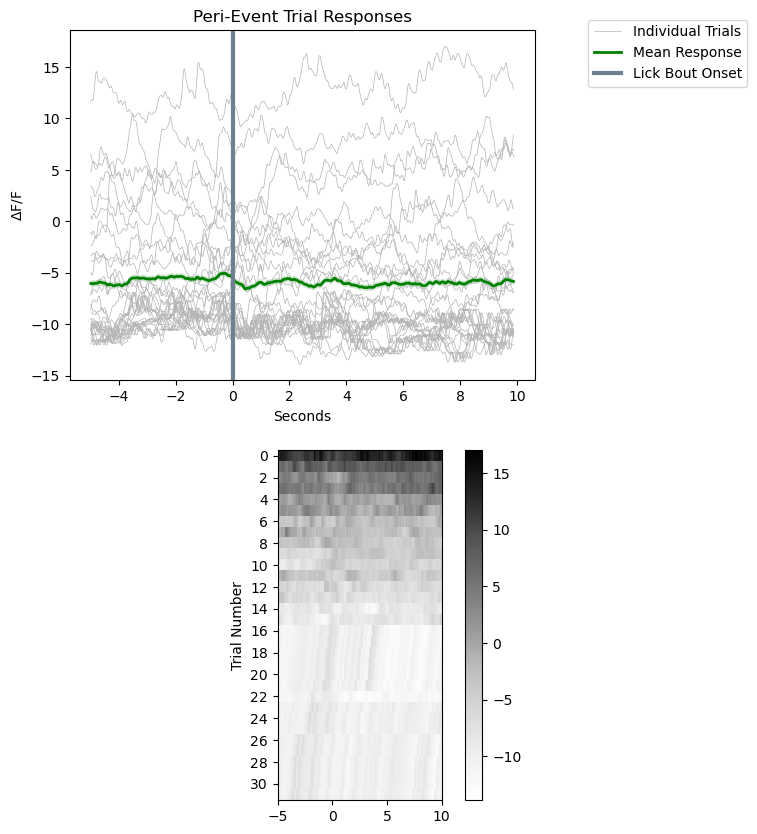

In [24]:
fig4 = plt.figure(figsize=(6,10))
ax5 = fig4.add_subplot(211)

for snip in dFF_snips:
    p1, = ax5.plot(peri_time, snip, linewidth=.5, color=[.7, .7, .7], label='Individual Trials')
p2, = ax5.plot(peri_time, mean_dFF_snips, linewidth=2, color='green', label='Mean Response')

# Plotting standard error bands
p3 = ax5.fill_between(peri_time, mean_dFF_snips+std_dFF_snips, 
                      mean_dFF_snips-std_dFF_snips, facecolor='green', alpha=0.2)
p4 = ax5.axvline(x=0, linewidth=3, color='slategray', label='Lick Bout Onset')

ax5.axis('tight')
ax5.set_xlabel('Seconds')
ax5.set_ylabel(r'$\Delta$F/F')
ax5.set_title('Peri-Event Trial Responses')
ax5.legend(handles=[p1, p2, p4], bbox_to_anchor=(1.1, 1.05));
ax6 = fig4.add_subplot(212)
cs = ax6.imshow(dFF_snips, cmap=plt.cm.Greys,
                interpolation='none', extent=[-PRE_TIME,POST_TIME,len(dFF_snips),0],)
ax6.set_ylabel('Trial Number')
ax6.set_yticks(np.arange(.5, len(dFF_snips), 2))
ax6.set_yticklabels(np.arange(0, len(dFF_snips), 2))
fig4.colorbar(cs)

